In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import label_binarize
from geopy.distance import vincenty
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.spatial import distance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
import matplotlib.patches as mpatches

import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.json', 'train.json']


In [2]:
class RentalListingEDA:
    """ This class summarizes the EDA performed """
    
    def __init__(self, trainFile):
        self.train_data = pd.read_json(trainFile)
        
    def basicDataCleaning(self):
        train_df = self.train_data
        
        # capping latitude and longitude - otherwise the plots skew's
        lat_max = np.percentile(train_df.latitude, 99)
        lat_min = np.percentile(train_df.latitude, 1)
        train_df.loc[train_df.latitude > lat_max, 'latitude'] = lat_max
        train_df.loc[train_df.latitude < lat_min, 'latitude'] = lat_min
        long_max = np.percentile(train_df.longitude, 99)
        long_min = np.percentile(train_df.longitude, 1)
        train_df.loc[train_df.longitude > long_max, 'longitude'] = long_max
        train_df.loc[train_df.longitude < long_min, 'longitude'] = long_min
        
        self.train_data = train_df
    
    def pricePlot(self):
        plt.figure(figsize=(7,7))

        x = self.train_data.price[self.train_data.interest_level == "low"].values
        y = self.train_data.price[self.train_data.interest_level == "medium"].values
        z = self.train_data.price[self.train_data.interest_level == "high"].values
        
        #plt.style.use('classic')
        bins = np.linspace(2000, 12000, 15)
        plt.hist([x, y, z], bins, label=['low', 'medium', 'high'], log = True)
        plt.xlabel('Price', fontsize=10)
        plt.legend(loc='upper right')
        plt.show()
        
    def managerSkillPlot(self):
        train_data = self.train_data
        train_labels = train_data.interest_level
        
        # computing manager skill 
        temp = pd.concat([train_data["manager_id"], pd.get_dummies(train_labels)], axis = 1).groupby("manager_id").mean()
        temp.rename(columns = {"high": "manager_id_high_frac", "medium": "manager_id_medium_frac", "low": "manager_id_low_frac"}, inplace = True)
        temp['manager_id_count'] = train_data.groupby("manager_id").count().iloc[:, 1]
        temp['manager_id_skill'] = temp['manager_id_high_frac'] * 2 + temp['manager_id_medium_frac']

        # adding for training data
        train_data = pd.merge(left = train_data, right = temp, how = 'left', left_on = "manager_id", right_index = True)
        
        plt.figure(figsize=(7,7))
        x = train_data.manager_id_skill[(train_data.manager_id_skill >= 0) & (train_data.interest_level == "low")].values
        y = train_data.manager_id_skill[(train_data.manager_id_skill >= 0) & (train_data.interest_level == "medium")].values
        z = train_data.manager_id_skill[(train_data.manager_id_skill >= 0) & (train_data.interest_level == "high")].values
        
        #plt.style.use('seaborn-deep')
        bins = np.linspace(0, 2, 15)
        plt.hist([x, y, z], bins, label=['low', 'medium', 'high'], log = True)
        plt.xlabel('Manager Skill Level', fontsize=10)
        plt.legend(loc='upper right')
        plt.show()

    def numDescWordsPlot(self):
        train_df = self.train_data

        # number of description words
        train_df['num_description_words'] = train_df['description'].apply(lambda x: len(x.split(' ')))
        train_df.loc[(train_df['num_description_words']>350, 'num_description_words')] = 350
        
        plt.figure(figsize=(5,5))
        sns.violinplot(y="num_description_words", x="interest_level", data=train_df, order =['low','medium','high'])
        plt.xlabel('Interest Level', fontsize=12)
        plt.ylabel('Number of Description words', fontsize=12)
        plt.show()
        
    def numPhotosPlot(self):
        train_df = self.train_data

        # number of photos
        train_df['num_photos'] = train_df['photos'].apply(len)
        train_df.loc[train_df['num_photos'] > 30, 'num_photos'] = 30
        plt.figure(figsize=(5,5))
        
        sns.violinplot(y="num_photos", x="interest_level", data=train_df, order =['low','medium','high'])
        plt.xlabel('Interest Level', fontsize=12)
        plt.ylabel('Number of Photos', fontsize=12)
    
    def numFeaturesPlot(self):
        train_df = self.train_data

        # number of features
        train_df["num_features"] = train_df["features"].apply(len)
        train_df.loc[train_df['num_features'] > 20, 'num_features'] = 20
        
        plt.figure(figsize=(7, 7))
        sns.violinplot(y = "num_features", x = "interest_level", data = train_df, order = ['low', 'medium', 'high'])
        plt.xlabel('Interest Level', fontsize=12)
        plt.ylabel('Number of features', fontsize=12)
        
    def descWordPlot(self):
        text_desc = ''
        for ind, row in self.train_data.iterrows():
            text_desc=" ".join([text_desc, row['description']])
        text_desc = text_desc.strip()
        
        plt.figure(figsize=(9, 8))
        wordcloud_desc = WordCloud(background_color='white', width=1000, height=800,
                              max_font_size=100, max_words=25).generate(text_desc)
        wordcloud_desc.recolor(random_state=0)
        plt.imshow(wordcloud_desc)
        #plt.title("Description", fontsize=20)
        plt.axis("off")
        plt.show()
        
    def featureWordPlot(self):
        text = ''
        for ind, row in self.train_data.iterrows():
            for feature in row['features']:
                text = " ".join([text, "_".join(feature.strip().split(" "))])
        text = text.strip()
        
        plt.figure(figsize=(9, 8))
        wordcloud = WordCloud(background_color='white', width=1000, height=800,
                              max_font_size=100, max_words=50).generate(text)
        wordcloud.recolor(random_state=0)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

    # plot - no of bedrooms and bathrooms
    def NumBedBathPlot(self):
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7, 7)
        train_df = self.train_data
        ax1.scatter(train_df[train_df['interest_level']=="low"]['bedrooms'],train_df[train_df['interest_level']=="low"]['bathrooms'],c='green',s=20)
        ax1.scatter(train_df[train_df['interest_level']=="medium"]['bedrooms'],train_df[train_df['interest_level']=="medium"]['bathrooms'],c='red',s=60)
        ax1.scatter(train_df[train_df['interest_level']=="high"]['bedrooms'],train_df[train_df['interest_level']=="high"]['bathrooms'],c='blue',s=100)
        ax1.set_xlabel('No. of Bedrooms')
        ax1.set_ylabel('No. of Bathrooms')
        ax1.legend(('Low','Medium','High'),scatterpoints=1,loc='upper right',fontsize=10,title="Interest Level")

    # plot - clusters - latitude & longitude
    def clusterPlot(self):
        df = pd.DataFrame()
        df['lat'] = self.train_data.latitude
        df['long'] = self.train_data.longitude
        df.reset_index(inplace = True, drop = True)
        kmeans = KMeans(n_clusters = 60, random_state = 2301).fit(df)
        id_label = kmeans.labels_
        plt.figure(figsize=(7, 7))
        plt.ylabel('Longitude', fontsize = 12)
        plt.xlabel('Latitude', fontsize = 12)
        for i in range(60):
            cluster = np.where(id_label == i)[0]
            plt.scatter(df.lat[cluster].values,df.long[cluster].values)#,ptsymb[i]
        plt.show()
    
    # plot - count - interest_level
    def countInterestLevel(self):
        plt.figure(figsize=(7, 7))
        labels = ["low","medium","high"]
        sizes = self.train_data.interest_level.value_counts().values
        explode=[0.1,0,0]
        colors = [  'lightcoral','gold','lightblue']
        patches, texts,autotexts= plt.pie(sizes, labels=labels,colors=colors,explode=explode,autopct="%1.1f%%",startangle=90)
        plt.show()
        
    # plot - Interest Distribution based on listing latitude and longitude
    def interestLtLongPlot(self):
        colors = {'high':'red', 'medium':'blue', 'low':'green'}
        plt.figure(figsize = (7, 7))
        plt.ylabel('Longitude', fontsize = 12)
        plt.xlabel('Latitude', fontsize = 12)
        plt.scatter(self.train_data['latitude'], self.train_data['longitude'], c = self.train_data['interest_level'].apply(lambda x: colors[x]), alpha = 0.5)
        plt.show()
    
    # plot - Distance from central park
    def distanceParkPlot(self):
        # central park corrdinates (40.7829, -73.9654)
        
        # for high interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'high'].latitude, self.train_data[self.train_data.interest_level == 'high'].longitude):
            plt.plot([40.7829, lat], [-73.9654, lon], linewidth = 1, alpha = 0.02, color = "red")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='red', label='High')
        plt.legend(handles=[red_patch])
        plt.show()
        
        # for medium interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'medium'].latitude, self.train_data[self.train_data.interest_level == 'medium'].longitude):
            plt.plot([40.7829, lat], [-73.9654, lon], linewidth = 1, alpha = 0.02, color = "red")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='red', label='Medium')
        plt.legend(handles=[red_patch])
        plt.show()
        
        # for low interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'low'].latitude, self.train_data[self.train_data.interest_level == 'low'].longitude):
            plt.plot([40.7829, lat], [-73.9654, lon], linewidth = 1, alpha = 0.02, color = "red")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='red', label='Low')
        plt.legend(handles=[red_patch])
        plt.show()
        
    # plot - Distance from city center
    def distanceCityCenterPlot(self):
        # City Center Coordinates (40.7128, -74.0060)
        
        # for high interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'high'].latitude, self.train_data[self.train_data.interest_level == 'high'].longitude):
            plt.plot([40.7128, lat], [-74.0060, lon], linewidth = 1, alpha = 0.02, color = "blue")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='blue', label='High')
        plt.legend(handles=[red_patch])
        plt.show()
        
        # for medium interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'medium'].latitude, self.train_data[self.train_data.interest_level == 'medium'].longitude):
            plt.plot([40.7829, lat], [-73.9654, lon], linewidth = 1, alpha = 0.02, color = "blue")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='blue', label='Medium')
        plt.legend(handles=[red_patch])
        plt.show()
        
        # for low interest listings
        plt.figure(figsize=(7, 7))
        for lat, lon in zip(self.train_data[self.train_data.interest_level == 'low'].latitude, self.train_data[self.train_data.interest_level == 'low'].longitude):
            plt.plot([40.7829, lat], [-73.9654, lon], linewidth = 1, alpha = 0.02, color = "blue")
        plt.ylabel('Longitude', fontsize=12)
        plt.xlabel('Latitude', fontsize=12)
        red_patch = mpatches.Patch(color='blue', label='Low')
        plt.legend(handles=[red_patch])
        plt.show()

In [3]:
# input's
train_data_file = "../input/train.json"

# getting data ready - feature engineering
eda = RentalListingEDA(train_data_file)
eda.basicDataCleaning()

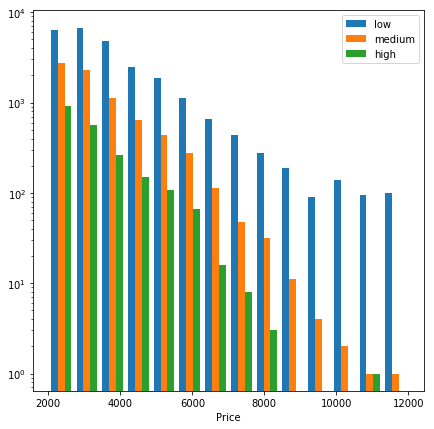

In [4]:
# price plot
eda.pricePlot()

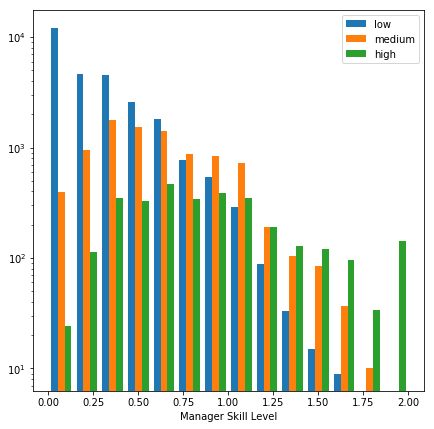

In [5]:
# manager Skill Plot
eda.managerSkillPlot()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


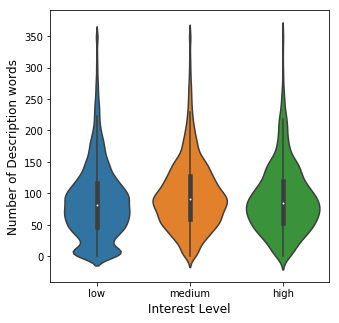

In [6]:
# number of description words vs interest level
eda.numDescWordsPlot()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


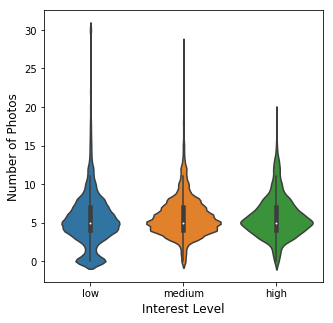

In [7]:
# number of phots vs interest level
eda.numPhotosPlot()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


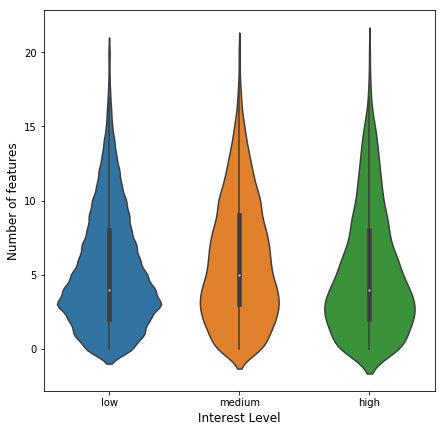

In [8]:
# number of features vs interest level
eda.numFeaturesPlot()

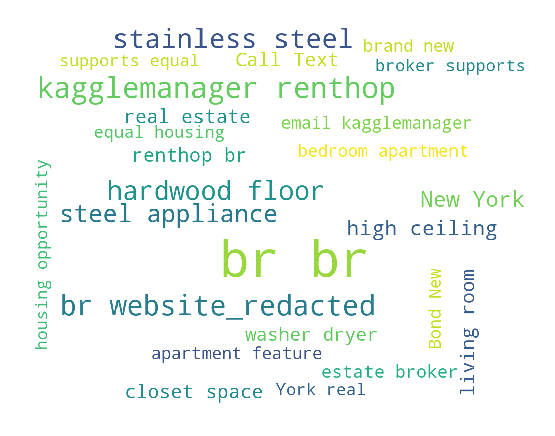

In [9]:
# description word cloud
eda.descWordPlot()

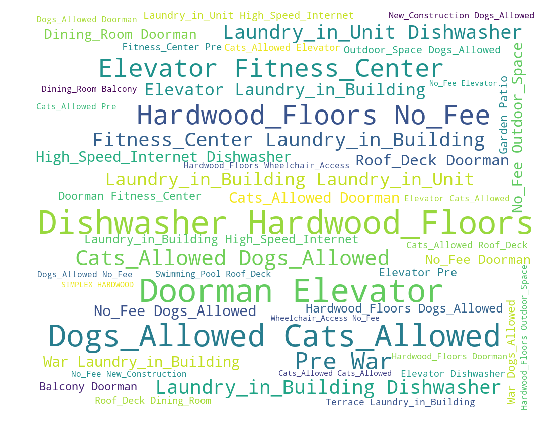

In [10]:
# feature cloud
eda.featureWordPlot()

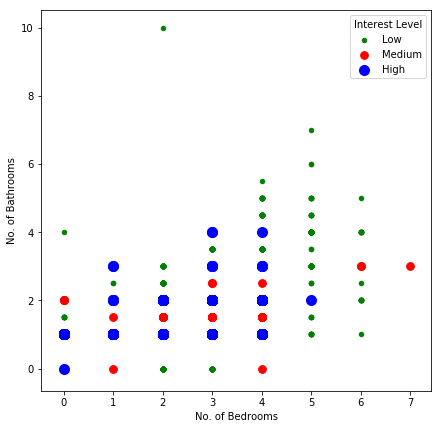

In [11]:
# Number of bedrooms and bathrooms
eda.NumBedBathPlot()

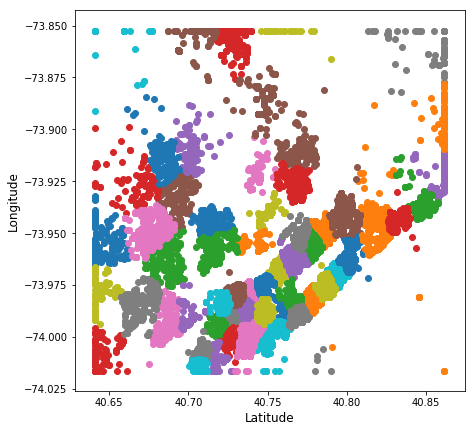

In [12]:
# clusters
eda.clusterPlot()

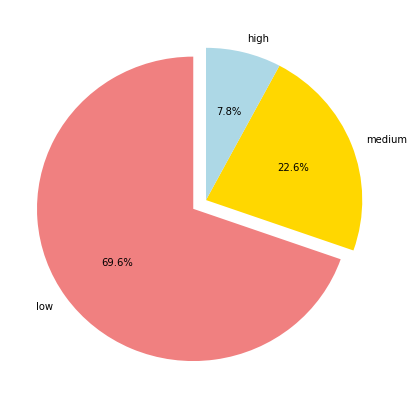

In [13]:
# plot interest level occurences
eda.countInterestLevel()

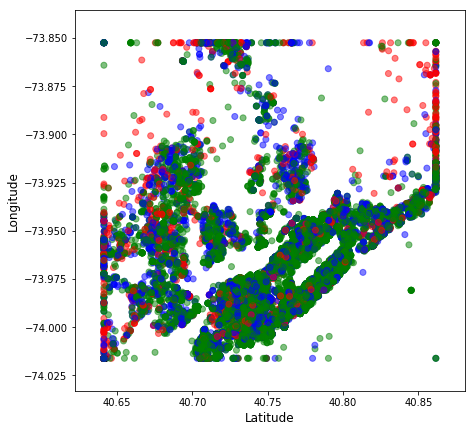

In [14]:
# plot interest distribution
eda.interestLtLongPlot()

In [15]:
# no accidental running

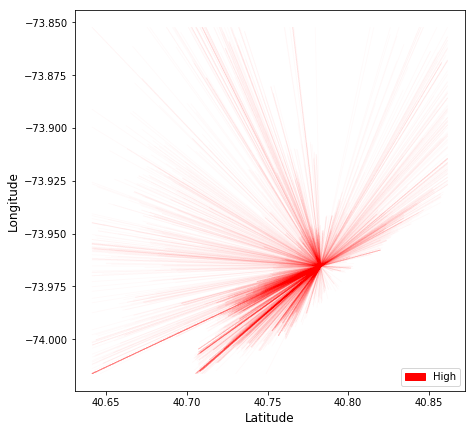

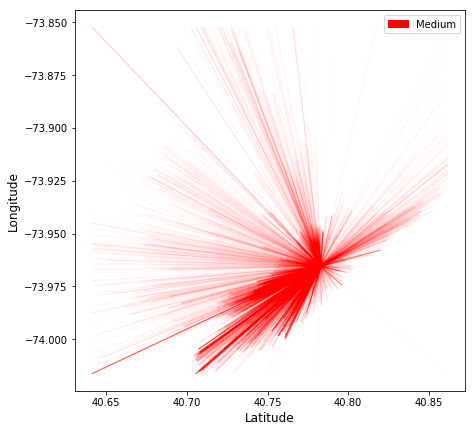

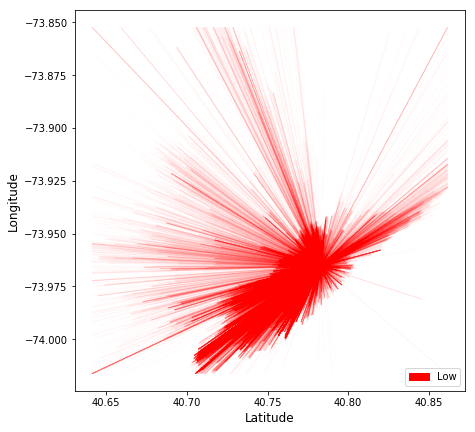

In [16]:
# plot distance park
eda.distanceParkPlot()

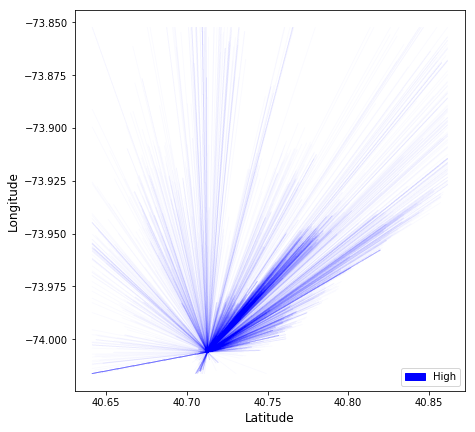

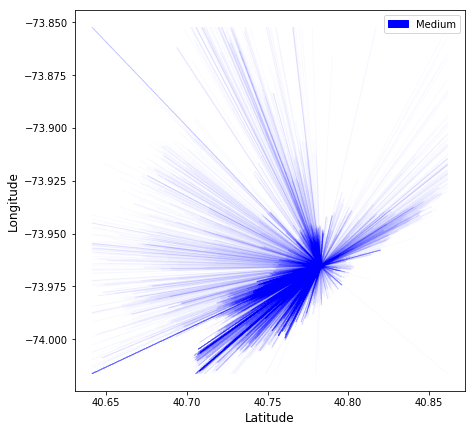

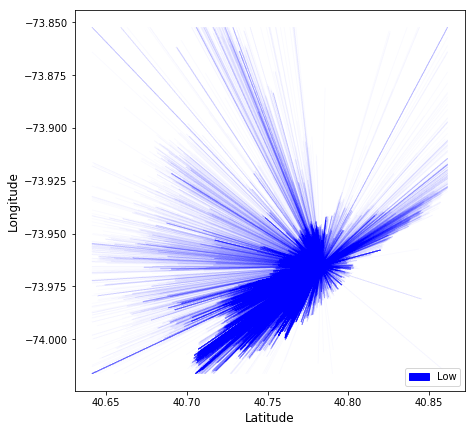

In [17]:
# plot city center
eda.distanceCityCenterPlot()